In [1]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


^C



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

In [9]:
# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

In [10]:
# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

In [11]:
# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

In [12]:
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found in total %d labels." % len(labels))

Found in total 400 labels.


In [13]:
ucf_videos = list_ucf_videos()
categories = {}
for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found in total %d videos in overall %d categories." % (len(ucf_videos), len(categories)))

print("\n")
head1 = "CATEGORY"
head2 = "No. of Videos"
head3 = "Details"
print(" ",head1," \t  ",head2," \t\t\t ",head3)
for category, sequences in categories.items():
  summary = ", ".join(sequences[:2])
  print("%-20s    %4d           %s, ..." % (category, len(sequences), summary))

Found in total 13320 videos in overall 101 categories.


  CATEGORY  	   No. of Videos  			  Details
ApplyEyeMakeup           145           v_ApplyEyeMakeup_g01_c01.avi, v_ApplyEyeMakeup_g01_c02.avi, ...
ApplyLipstick            114           v_ApplyLipstick_g01_c01.avi, v_ApplyLipstick_g01_c02.avi, ...
Archery                  145           v_Archery_g01_c01.avi, v_Archery_g01_c02.avi, ...
BabyCrawling             132           v_BabyCrawling_g01_c01.avi, v_BabyCrawling_g01_c02.avi, ...
BalanceBeam              108           v_BalanceBeam_g01_c01.avi, v_BalanceBeam_g01_c02.avi, ...
BandMarching             155           v_BandMarching_g01_c01.avi, v_BandMarching_g01_c02.avi, ...
BaseballPitch            150           v_BaseballPitch_g01_c01.avi, v_BaseballPitch_g01_c02.avi, ...
BasketballDunk           131           v_BasketballDunk_g01_c01.avi, v_BasketballDunk_g01_c02.avi, ...
Basketball               134           v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...
BenchPress  

In [14]:
video_path = fetch_ucf_video("v_LongJump_g01_c01.avi")
sample_video = load_video(video_path)
sample_video1 = load_video(video_path)[:100]
sample_video.shape

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_LongJump_g01_c01.avi => /tmp/tmpijim5wu7/v_LongJump_g01_c01.avi


(143, 224, 224, 3)

In [19]:

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, duration=1/25)  # Adjust the duration as needed
    return embed.embed_file('./animation.gif')


In [20]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [21]:
def predict(sample_video):
  # Add a batch axis to the to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  probabilities = tf.nn.softmax(logits)

  print("Top 5 actions:")
  for i in np.argsort(probabilities)[::-1][:5]:
    print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")

In [22]:
predict(sample_video)

Top 5 actions:
  long jump             : 62.05%
  triple jump           : 37.88%
  hurdling              :  0.06%
  pole vault            :  0.01%
  high jump             :  0.00%


In [23]:
video_path = fetch_ucf_video("v_WritingOnBoard_g01_c01.avi")
sample_video = load_video(video_path)
sample_video1 = load_video(video_path)[:100]
sample_video.shape

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_WritingOnBoard_g01_c01.avi => /tmp/tmpijim5wu7/v_WritingOnBoard_g01_c01.avi


(153, 224, 224, 3)


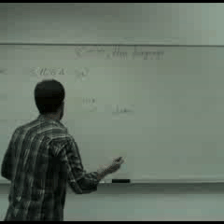

In [24]:
to_gif(sample_video1)

In [25]:
predict(sample_video)

Top 5 actions:
  writing               : 99.85%
  spray painting        :  0.01%
  beatboxing            :  0.01%
  ice fishing           :  0.01%
  smoking               :  0.01%


In [26]:
video_path = fetch_ucf_video("v_PlayingGuitar_g01_c02.avi")
sample_video = load_video(video_path)
sample_video1 = load_video(video_path)[:100]
sample_video.shape

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_PlayingGuitar_g01_c02.avi => /tmp/tmpijim5wu7/v_PlayingGuitar_g01_c02.avi


(250, 224, 224, 3)


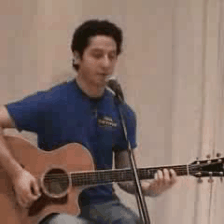

In [27]:
to_gif(sample_video1)

In [28]:
predict(sample_video)

Top 5 actions:
  playing guitar        : 89.51%
  strumming guitar      :  9.17%
  busking               :  0.35%
  playing drums         :  0.28%
  recording music       :  0.23%
